# Classify using transfer learning
* Load the data
* Load pre-trained model MobileNetV3Small
* Fit the classifier including the pre-trained model and a dense network
* Save the fitted classifier

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, RandomBrightness
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

import numpy as np
from os.path import join
import pickle
from sklearn.model_selection import train_test_split

from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

2025-01-31 17:09:06.793462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 17:09:06.803687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738339746.814094   29969 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738339746.817179   29969 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 17:09:06.830210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Global variables

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [3]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 7

# size of sample used to train the model
NUM_SAMPLES = 10000

# Rescale the data (color) values
scale = False  # rather not

## Load the data
* Load the data prepared in previous notebook
* Optionally subsample the data for faster training during try-outs
* Optionally rescale the image data, one-hot encode the labels
* Display some images for checking

Load the data prepared in previous notebook

In [18]:
with np.load(join(DATA_PATH, 'train_data.npz')) as data:
    data_dict=dict(data.items())
X_train = data_dict['X']
y_train = data_dict['y']

Optionally subsample the data for faster training during try-outs

In [6]:
import random

# Get a smaller random sample 
idx = random.sample(range(len(X_train)-1), NUM_SAMPLES)
X_train_rnd = X_train[idx]
y_train_rnd = y_train[idx]

Optionally rescale the image data, one-hot encode the labels

In [7]:
if scale:
    # Rescale train and validation data
    scaler = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train_rnd.reshape([-1, input_dim])).reshape([-1, input_width, input_height, input_depth])
    X_test_preprocessed = scaler.transform(X_test.reshape([-1,input_dim])).reshape([-1, input_width, input_height, input_depth])
else:
    X_train_preprocessed = X_train_rnd
    X_test_preprocessed = X_test

classes, y_train_classes = np.unique(y_train_rnd, return_inverse=True)
y_train_preprocessed = to_categorical(y_train_classes, num_classes=output_classes)
_, y_test_classes = np.unique(y_test, return_inverse=True)
y_test_preprocessed = to_categorical(y_test_classes, num_classes=output_classes)

print('Train:', X_train_preprocessed.shape)
print('Test:', X_test_preprocessed.shape)

Train: (10000, 300, 300, 3)
Test: (3841, 300, 300, 3)


Display some images for checking

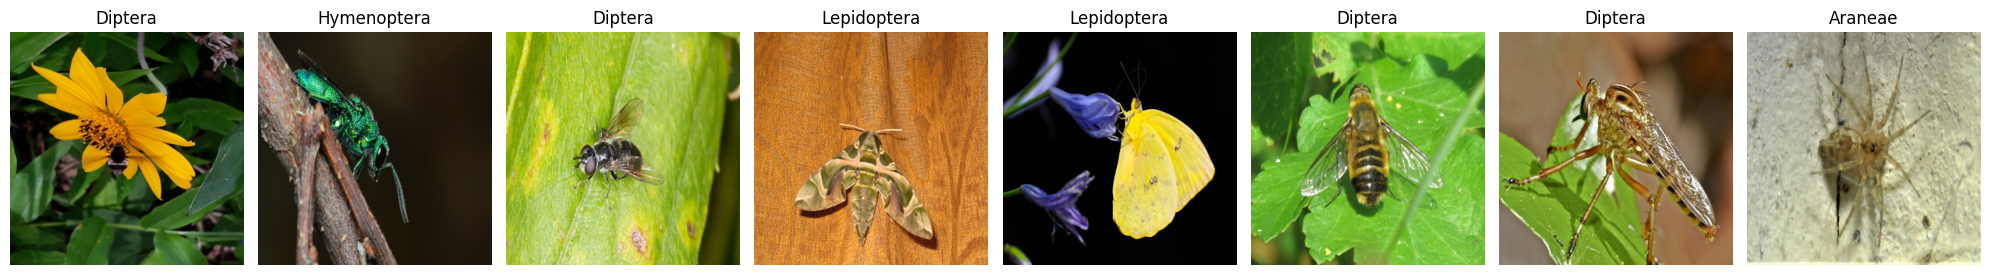

In [8]:
check_images = 8
idx = random.sample(range(len(X_train_preprocessed)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X_train_preprocessed[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    ax[i].set_title(classes[y_train_classes[id]])
    ax[i].axis('off')
plt.tight_layout()
plt.show();

## Transfer learning
* Load pre-trained model
* Define the classifier
* Fit the classifier

Load pre-trained model

In [9]:
backbone = tf.keras.applications.MobileNetV3Small(
    input_shape=(input_width, input_height, input_depth),
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights='imagenet',
    dropout_rate=0.2,
    include_preprocessing=True
)
backbone.trainable = False

/home/atroncos/workspace/oa_venv/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
2025-01-16 09:34:25.893110: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Define the local model

In [10]:
input = Input(shape=(input_width, input_height, input_depth))

x = backbone(input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)

output = Dense(output_classes, activation='softmax')(x)

model = Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 10, 10, 576)    │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168,047 (4.46 MB)

 Trainable params: 724,999 (2.77 MB)

 Non-trainable params: 443,048 (1.69 MB)

In [11]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy')]
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = loss_function,
    metrics = metrics
)

## Fit the model

In [12]:
%%time

tf.config.run_functions_eagerly(True)
# Fit model
history = model.fit(
    x=X_train_preprocessed, y=y_train_preprocessed,
    validation_split=0.2,
    batch_size=32, epochs=20,
)

/home/atroncos/workspace/oa_venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.4894 - loss: 1.5119 - val_accuracy: 0.5830 - val_loss: 1.1682
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.6616 - loss: 0.9323 - val_accuracy: 0.6125 - val_loss: 1.1024
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.7260 - loss: 0.7577 - val_accuracy: 0.6450 - val_loss: 1.0270
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.7665 - loss: 0.6627 - val_accuracy: 0.6185 - val_loss: 1.1093
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 222s 889ms/step - accuracy: 0.7937 - loss: 0.5828 - val_accuracy: 0.6210 - val_loss: 1.1743
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 752ms/step - accuracy: 0.8193 - loss: 0.5096 - val_accuracy: 0.5870 - val_loss: 1.3417
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 199s 798ms/step - accuracy: 0.8299 - loss: 0.4735 - val_accuracy: 0.6090 - val_loss: 1.3727
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.8567 - loss: 0.4093 -

Display validation loss and accuracy

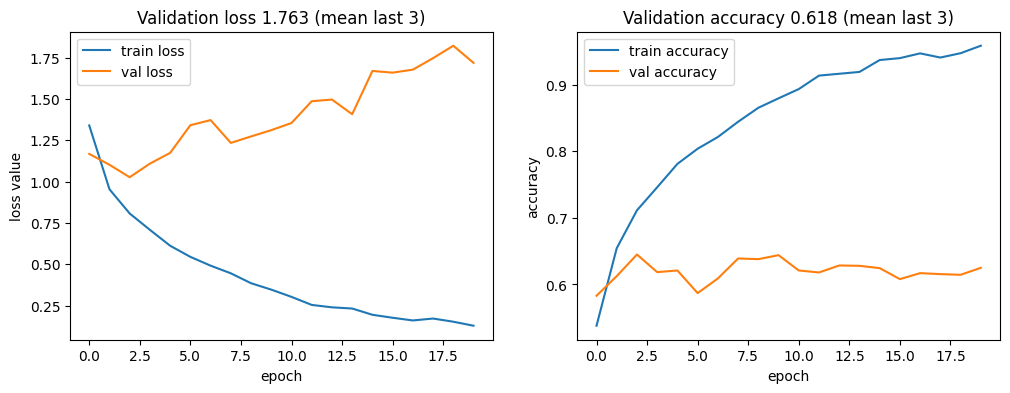

In [13]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()


## Save the model

In [16]:
with open(join(MODELS_PATH, 'transfer_mobilenet.pickle'), 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)